The goal of this final phase of the project is to build a text categorization model on your primary dataset, and to evaluate it on both your primary and your secondary dataset.  Follow the steps below.

## Data Partitioning

1. Data partitioning: Create a Training set for your model by randomly selecting 70% of the texts in your PRIMARY dataset.  Use the remaining 30% of texts from the PRIMARY dataset as your Test (PRIMARY) set.  Designate 100% of your SECONDARY dataset as the Test (SECONDARY) dataset.  So you should have one Training set (drawn from the PRIMARY data), and two different Test sets (one from PRIMARY and one from SECONDARY).

In [1]:
!pip3 install yake
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from pprint import pprint
import yake

In [2]:
#import data and simultaneous convert uppercase to lowercase
primary = pd.read_csv('primary_labels.csv', 
                    dtype=str).apply(lambda x: x.astype(str).str.lower())

secondary = pd.read_csv('secondary_labels.csv',
                   dtype=str).apply(lambda x: x.astype(str).str.lower())


#Randomly Split Primary Data into Training Set (70%) and Testing Set (30%)

X = primary.iloc[:, :-1]
y = primary.iloc[:, -1]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, train_size=0.7)


#Prep Secondary Data for Testing (100% of data)
X_sec = secondary.iloc[:, :-1]
y_sec = secondary.iloc[:, -1]


2. Baseline model training: Train a simple bag-of-words classifier on your Training dataset.  If your data comes from the stance task, you will build a multiclass model (one which can assign one of three labels - pro-mitigation, anti-mitigation, or unclear).  If your data comes from the topic task, choose only one of the topics (masking and distancing, lockdowns, vaccination) to model as a binary classification task.  (You should avoid topics with low numbers of positive examples.)  An example of how to use scikit-learn to build a simple text categorization model is here. (https://blackboard.iit.edu/ultra/courses/_119779_1/cl/outline)  The course sample notebooks here and here may also be useful as examples.

In [3]:
#Text Cleaning
import string
import re
import nltk  #natural language toolkit
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
lemmatizer = WordNetLemmatizer()


def txt_clean(txt):
    #remove punctuation
    txt = "".join([c for c in txt if c not in string.punctuation])
    #create word tokens
    tokens = re.split('\W+', txt)
    #stem word after tokenizing
    #txt = [ps.stem(word) for word in tokens] #if word not in stopwords]
    txt = [lemmatizer.lemmatize(word) for word in tokens] 
    return " ".join(txt)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/userina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/userina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#Functions created and used to complete steps 2-5.

def create_basemodel(X_train, y_train):
    #Vectorize and tf*idf with PRIMARY training data
    vectorizer = TfidfVectorizer( stop_words="english")
    vectorizer = vectorizer.fit([txt_clean(i[1].text) for i in X_train.iterrows()])
    X_vect = vectorizer.transform([txt_clean(i[1].text) for i in X_train.iterrows()])

    y_vect = [t for t in y_train]
    # Random Forest Model PRIMARY
    rf_model = RandomForestClassifier().fit(X_vect, y_vect)
    return rf_model, vectorizer


def create_newFeatureModel(X_train, y_train):
    #Vectorize and tf*idf with PRIMARY training data
    vectorizer = TfidfVectorizer( stop_words="english")
    vectorizer = vectorizer.fit([add_feat(i[1].text) for i in X_train.iterrows()])
    X_vect = vectorizer.transform([add_feat(i[1].text) for i in X_train.iterrows()])

    y_vect = [t for t in y_train]
    # Random Forest Model PRIMARY
    rf_model = RandomForestClassifier().fit(X_vect, y_vect)
    return rf_model, vectorizer

def predict_and_evaluate(model,xtest,ytest):
    # Random Forest Model
    y_hat_rf_base_test = model.predict(xtest)
    return classification_report(ytest, y_hat_rf_base_test,output_dict=True)

def get_average_answers(accTests):
    average_answers = {'anti-mitigation': {'precision': 0.0,
                                           'recall': 0.0,
                                           'f1-score': 0.0
                                           , 'support': 0},
                       'pro-mitigation': {'precision': 0.0,
                                          'recall': 0.0,
                                          'f1-score': 0.0,
                                          'support': 0},
                       'unclear': {'precision': 0.0,
                                          'recall': 0.0,
                                          'f1-score': 0.0,
                                          'support': 0},
                       'accuracy': 0.0,
                       'macro avg': {'precision': 0.0,
                                     'recall': 0.0,
                                     'f1-score': 0.0,
                                     'support': 0},

                      'weighted avg': {'f1-score': 0.0,
                      'precision': 0.0,
                      'recall': 0.0,
                      'support': 0}
                      }
    for runs in accTests:
        for keyElement in runs:
            if keyElement != "accuracy":
                for score in runs[keyElement]:
                    average_answers[keyElement][score] += runs[keyElement][score]
            else:
                average_answers[keyElement] +=runs[keyElement]
    for keyElement in average_answers:
        if keyElement != "accuracy":
            for score in average_answers[keyElement]:
                average_answers[keyElement][score] = average_answers[keyElement][score] / len(accTests)
        else:
            average_answers[keyElement] = average_answers[keyElement] / len(accTests)
    return average_answers


def add_feat(txt):
    #remove punctuation
    txt = "".join([c for c in txt if c not in string.punctuation])
    #create word tokens 
    tokens = re.split('\W+', txt)
    txt = [lemmatizer.lemmatize(word) for word in tokens]
    if "cdc" in txt and 'guideline' in txt :
        if 'mask' in txt or 'school' in txt or 'make' in txt:
            txt.append("86967b9aaac70ec94683ff0e768bcd03") #anti md5 hash
        elif 'released' in txt or 'due' in txt:
            txt.append("05cac50f47bd9793a1578ddc85de1393") #unclear md5 hash
    if "cdc" in txt and 'guidelines' in txt :
        if 'follow' in txt:
            txt.append("86967b9aaac70ec94683ff0e768bcd03") #Anti
        elif 'travel' in txt:
            txt.append("05cac50f47bd9793a1578ddc85de1393") #unclear
    #Results from Keywords extractions for Anti-mitigation label in training data
        #{'cdc travel guidelines', 'released cdc guideline', 'cdc guideline due'}
    #Results from Keywords extractions for unclear label in training data
        #{'cdc school guideline', 'cdc make guideline', 'cdc mask guideline', 'follow cdc guidelines'}
    #Pro-mitigation returned only keywords that were already included in the other label sets

    grams = []
    #bi-grams
    for n in range(len(txt)-1):
        grams.append("-".join(txt[n:n+2]))
    #tri-grams
    for m in range(len(txt)-2):
        grams.append("-".join(txt[m:m+3]))
    return ' '.join(txt+grams)
    


In [5]:
#Investigation to determine new features
kw_extractor = yake.KeywordExtractor()
text = """spaCy is an open-source software library for advanced natural language processing, written in the programming languages Python and Cython. The library is published under the MIT license and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion."""
text = " ".join([i[1].text for i in X_train.loc[y_train=="anti-mitigation",:].iterrows()])
text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 100
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)
antiset=set()
for kw in keywords:
    #print(kw)
    antiset.add(kw[0])    

text = " ".join([i[1].text for i in X_train.loc[y_train=="pro-mitigation",:].iterrows()])
text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 100
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)
proset = set()
for kw in keywords:
    #print(kw)
    proset.add(kw[0])

text = " ".join([i[1].text for i in X_train.loc[y_train=="unclear",:].iterrows()])
text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 15
custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                            n=max_ngram_size, dedupLim=deduplication_threshold, 
                                            top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(text)
unclearset = set()
for kw in keywords:
    #print(kw)
    unclearset.add(kw[0])

#print("AntiSet\n\n")
#print( (antiset - proset ) - unclearset )
#Result: {'cdc school guideline', 'cdc mask guideline', 'follow cdc guidelines'}

#print(proset - antiset)
#print("ProSet\n\n")
#print( ( proset -antiset ) - unclearset )
#Result: {'follow cdc guideline'}

#print("UnclearSet\n\n")
#print( (unclearset - proset ) -antiset  )
#Result: {'cdc travel guidelines', 'released cdc guideline', 'cdc guideline due'}

3. Model evaluation 1: Calculate your baseline model's accuracy for your model's predictions on the Test (PRIMARY) set, and on the Test (SECONDARY) set. Enter these values in the answer boxes provided.

In [6]:
#Running and evaluating the base model Primary Dataset
accRuns=[]
for x in range(50):
    model , vectorizer = create_basemodel(X_train,y_train)
    testdata= vectorizer.transform([txt_clean(i[1].text) for i in X_test.iterrows()])
    accRuns.append(predict_and_evaluate(model,testdata,y_test))
pprint(get_average_answers(accRuns))

{'accuracy': 0.5493333333333333,
 'anti-mitigation': {'f1-score': 0.12152114229335927,
                     'precision': 0.575888888888889,
                     'recall': 0.06823529411764703,
                     'support': 51.0},
 'macro avg': {'f1-score': 0.4275972150902468,
               'precision': 0.5664273295964317,
               'recall': 0.45233445378151266,
               'support': 270.0},
 'pro-mitigation': {'f1-score': 0.5096797678503351,
                    'precision': 0.5911346506958752,
                    'recall': 0.4486,
                    'support': 100.0},
 'unclear': {'f1-score': 0.6515907351270459,
             'precision': 0.532258449204531,
             'recall': 0.8401680672268905,
             'support': 119.0},
 'weighted avg': {'f1-score': 0.49890686119301214,
                  'precision': 0.5623057550305925,
                  'recall': 0.5493333333333333,
                  'support': 270.0}}


In [7]:
#Running and evaluating the base model Secondary dataset
accRuns=[]
for x in range(50):
    model , vectorizer = create_basemodel(X_train,y_train)
    testdata= vectorizer.transform([txt_clean(i[1].text) for i in X_sec.iterrows()])
    accRuns.append(predict_and_evaluate(model,testdata,y_sec))
pprint(get_average_answers(accRuns))

{'accuracy': 0.48455104551045525,
 'anti-mitigation': {'f1-score': 0.026625445437879466,
                     'precision': 0.06494597289245252,
                     'recall': 0.016962025316455694,
                     'support': 79.0},
 'macro avg': {'f1-score': 0.3508999290415169,
               'precision': 0.3857168687740018,
               'recall': 0.4008631877326651,
               'support': 813.0},
 'pro-mitigation': {'f1-score': 0.49822672683981184,
                    'precision': 0.6974427005512731,
                    'recall': 0.38836518046709123,
                    'support': 471.0},
 'unclear': {'f1-score': 0.5278476148468589,
             'precision': 0.39476193287827954,
             'recall': 0.7972623574144485,
             'support': 263.0},
 'weighted avg': {'f1-score': 0.46198292894940685,
                  'precision': 0.5380671982351055,
                  'recall': 0.48455104551045525,
                  'support': 813.0}}


In [8]:
#Running and evaluating the Featured model Primary Data
accRuns=[]
for x in range(50):
    model , vectorizer = create_newFeatureModel(X_train,y_train)
    testdata= vectorizer.transform([add_feat(i[1].text) for i in X_test.iterrows()])
    accRuns.append(predict_and_evaluate(model,testdata,y_test))
pprint(get_average_answers(accRuns))

{'accuracy': 0.5468148148148149,
 'anti-mitigation': {'f1-score': 0.12555582655078834,
                     'precision': 0.5345238095238096,
                     'recall': 0.07137254901960782,
                     'support': 51.0},
 'macro avg': {'f1-score': 0.42364879518791004,
               'precision': 0.5544758646155242,
               'recall': 0.44924967320261433,
               'support': 270.0},
 'pro-mitigation': {'f1-score': 0.4902528963464223,
                    'precision': 0.6001310549874115,
                    'recall': 0.4152,
                    'support': 100.0},
 'unclear': {'f1-score': 0.6551376626665195,
             'precision': 0.5287727293353525,
             'recall': 0.8611764705882352,
             'support': 119.0},
 'weighted avg': {'f1-score': 0.49403710609647505,
                  'precision': 0.5562880539828235,
                  'recall': 0.5468148148148149,
                  'support': 270.0}}


In [9]:
#Running and evaluating the Featured model Secondary Data
accRuns=[]
for x in range(50):
    model , vectorizer = create_newFeatureModel(X_train,y_train)
    testdata= vectorizer.transform([add_feat(i[1].text) for i in X_sec.iterrows()])
    accRuns.append(predict_and_evaluate(model,testdata,y_sec))
pprint(get_average_answers(accRuns))

{'accuracy': 0.43092250922509234,
 'anti-mitigation': {'f1-score': 0.022961554157652615,
                     'precision': 0.060907477083937914,
                     'recall': 0.014430379746835446,
                     'support': 79.0},
 'macro avg': {'f1-score': 0.3053136939392358,
               'precision': 0.36652361305493764,
               'recall': 0.37687183494487564,
               'support': 813.0},
 'pro-mitigation': {'f1-score': 0.381287581485797,
                    'precision': 0.6721912533738492,
                    'recall': 0.2675159235668791,
                    'support': 471.0},
 'unclear': {'f1-score': 0.5116919461742576,
             'precision': 0.3664721087070255,
             'recall': 0.8486692015209125,
             'support': 263.0},
 'weighted avg': {'f1-score': 0.38865362300380646,
                  'precision': 0.5138941397523515,
                  'recall': 0.43092250922509234,
                  'support': 813.0}}


4. Feature engineering: In order to try to improve your model, think about what features of the text might be associated with the category you are trying to predict.  What attributes of a text besides the presence of individual words might be good predictors (for example, regular expression patterns or specific word sequences)?  Create at least three new features that represent attributes of the text.  Add them to your model and retrain.  An example of how to add a set of features (defined as a vector of 1/0 values indicating whether the attribute is present or absent for a given text) is shown here. (https://gist.github.com/DerrickHiggins/20c77745b080e3d493231424d7da9a2f)

In [10]:
#Attempts with other classifiers

#Vectorize and tf*idf with PRIMARY training data
#vectorizer = TfidfVectorizer( stop_words="english")
#vectorizer = vectorizer.fit([add_feat(i[1].text) for i in X_train.iterrows()])
#X_vect = vectorizer.transform([add_feat(i[1].text) for i in X_train.iterrows()])

#y_vect = [t for t in y_train]
#print(y_vect)

#Naive Bayes Model PRIMARY
#nb_model = MultinomialNB(alpha=1.0).fit(X_vect, y_vect)
#X_test_vect = vectorizer.transform([add_feat(i[1].text) for i in X_test.iterrows()])
#y_hat_nb_test = nb_model.predict(X_test_vect)


#Naive Bayes Model SECONDARY
#X_test_vect_sec= vectorizer.transform([add_feat(i[1].text) for i in X_sec.iterrows()])
#y_hat_nb_test_sec = nb_model.predict(X_test_vect_sec)


#Logistic Regression Model PRIMARY
#lr_model = LogisticRegression(penalty="none", 
#                              multi_class="multinomial",
#                              solver="lbfgs").fit(X_vect, y_vect)
#y_hat_lr_test = lr_model.predict(X_test_vect)


#Logistic Regression Model SECONDARY
#y_hat_lr_test_sec = lr_model.predict(X_test_vect_sec)


# Random Forest Model PRIMARY
#rf_model = RandomForestClassifier().fit(X_vect, y_vect)
#y_hat_rf_featEng_test = rf_model.predict(X_test_vect)


# Random Forest Model SECONDARY
#y_hat_rf_featEng_test_sec = rf_model.predict(X_test_vect_sec)


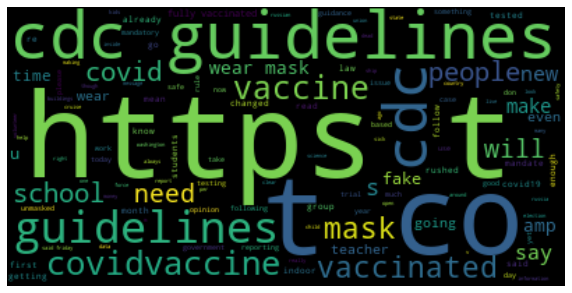

In [11]:
#Investigating new features

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordclou = WordCloud(stopwords=STOPWORDS).generate(" ".join([i[1].text for i in X_train.loc[y_train=="anti-mitigation",:].iterrows()]))
plt.figure(figsize=(10,10))
plt.imshow(wordclou, interpolation="bilinear")
plt.axis("off")
plt.show()

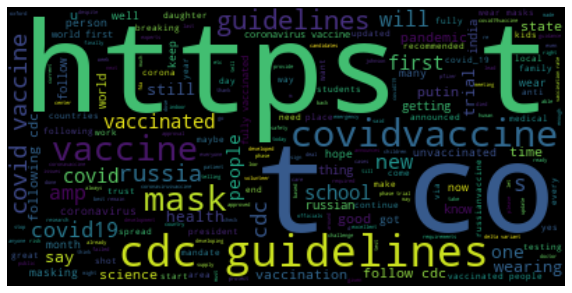

In [12]:
#Investigating new features
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordclou = WordCloud(stopwords=STOPWORDS).generate(" ".join([i[1].text for i in X_train.loc[y_train=="pro-mitigation",:].iterrows()]))
plt.figure(figsize=(10,10))
plt.imshow(wordclou, interpolation="bilinear")
plt.axis("off")
plt.show()

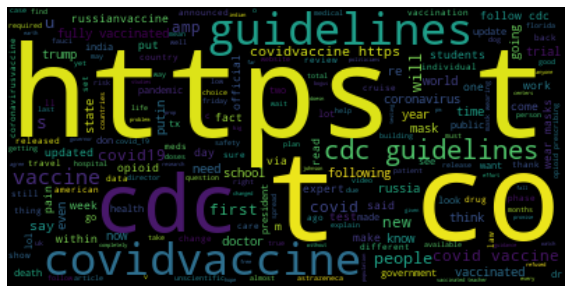

In [13]:
#Investigating new features
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordclou = WordCloud(stopwords=STOPWORDS).generate(" ".join([i[1].text for i in X_train.loc[y_train=="unclear",:].iterrows()]))
plt.figure(figsize=(10,10))
plt.imshow(wordclou, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
#POS TAGGING 
import nltk

# download required nltk packages
# required for tokenization
nltk.download('punkt')
# required for parts of speech tagging
nltk.download('averaged_perceptron_tagger')

#remove punctuation
txt = "".join([c[1].text for c in X_train.iterrows() if c[1].text not in string.punctuation])
#create word tokens
tokens = re.split('\W+', txt)

#txt = [word for word in tokens]


# input text
#sentence = """Today morning, Arthur felt very good."""

# tokene into words
#tokens = nltk.word_tokenize(sentence)

# parts of speech tagging
tagged = nltk.pos_tag(tokens)

# print tagged tokens
print(tagged)

[nltk_data] Downloading package punkt to /home/userina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/userina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('and', 'CC'), ('now', 'RB'), ('they', 'PRP'), ('call', 'VBP'), ('our', 'PRP$'), ('hope', 'NN'), ('for', 'IN'), ('any', 'DT'), ('covidvaccine', 'JJ'), ('delusional', 'JJ'), ('https', 'NN'), ('t', 'NN'), ('co', 'JJ'), ('jbe8hzujc5labor', 'NN'), ('day', 'NN'), ('at', 'IN'), ('the', 'DT'), ('earliest', 'JJS'), ('doc', 'NN'), ('and', 'CC'), ('if', 'IN'), ('there', 'EX'), ('isn', 'VBP'), ('t', 'VB'), ('a', 'DT'), ('covidvaccine', 'NN'), ('by', 'IN'), ('then', 'RB'), ('the', 'DT'), ('time', 'NN'), ('has', 'VBZ'), ('come', 'VBN'), ('for', 'IN'), ('massive', 'JJ'), ('investm', 'NN'), ('https', 'NN'), ('t', 'NN'), ('co', 'NN'), ('bn2eq88bgwethealthworld', 'NN'), ('vaccine', 'NN'), ('storage', 'NN'), ('demands', 'NNS'), ('could', 'MD'), ('leave', 'VB'), ('3b', 'CD'), ('people', 'NNS'), ('in', 'IN'), ('virus', 'NN'), ('cold', 'JJ'), ('covidvaccine', 'NN'), ('unicef', 'JJ'), ('coronavirus', 'NN'), ('https', 'NN'), ('t', 'NN'), ('co', 'NN'), ('ipg1ppblk3such', 'PDT'), ('a', 'DT'), ('great', 'JJ'),

5. Model evaluation 2: Calculate overall model accuracy for your new model's predictions on the Test (PRIMARY) set, and on the Test (SECONDARY) set.  Enter these values in the answer boxes provided.